In [1]:
import torch
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T

print(torch.__version__)
print(torchaudio.__version__)

1.9.0
0.9.0a0+33b2469


In [2]:
import io
import os
import math
import tarfile
import multiprocessing

import scipy
import librosa
#import boto3
#from botocore import UNSIGNED
#from botocore.config import Config
import requests
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import Audio, display

[width, height] = matplotlib.rcParams['figure.figsize']
if width < 10:
    matplotlib.rcParams['figure.figsize'] = [width * 2.5, height]

def _get_sample(path, resample=None):
    effects = [
        ["remix", "1"]
    ]
    if resample:
            effects.append(["rate", f'{resample}'])
    return torchaudio.sox_effects.apply_effects_file(path, effects=effects)

def get_speech_sample(*, resample=None):
    return _get_sample(SAMPLE_WAV_SPEECH_PATH, resample=resample)

def get_sample(*, resample=None):
    return _get_sample(SAMPLE_WAV_PATH, resample=resample)

def get_rir_sample(*, resample=None, processed=False):
    rir_raw, sample_rate = _get_sample(SAMPLE_RIR_PATH, resample=resample)
    if not processed:
        return rir_raw, sample_rate
    rir = rir_raw[:, int(sample_rate*1.01):int(sample_rate*1.3)]
    rir = rir / torch.norm(rir, p=2)
    rir = torch.flip(rir, [1])
    return rir, sample_rate

def get_noise_sample(*, resample=None):
    return _get_sample(SAMPLE_NOISE_PATH, resample=resample)

def print_metadata(metadata, src=None):
    if src:
        print("-" * 10)
        print("Source:", src)
        print("-" * 10)
    print(" - sample_rate:", metadata.sample_rate)
    print(" - num_channels:", metadata.num_channels)
    print(" - num_frames:", metadata.num_frames)
    print(" - bits_per_sample:", metadata.bits_per_sample)
    print(" - encoding:", metadata.encoding)
    print()

def print_stats(waveform, sample_rate=None, src=None):
    if src:
        print("-" * 10)
        print("Source:", src)
        print("-" * 10)
    if sample_rate:
        print("Sample Rate:", sample_rate)
    print("Shape:", tuple(waveform.shape))
    print("Dtype:", waveform.dtype)
    print(f" - Max:     {waveform.max().item():6.3f}")
    print(f" - Min:     {waveform.min().item():6.3f}")
    print(f" - Mean:    {waveform.mean().item():6.3f}")
    print(f" - Std Dev: {waveform.std().item():6.3f}")
    print()
    print(waveform)
    print()

def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None, ylim=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f'Channel {c+1}')
        if xlim:
            axes[c].set_xlim(xlim)
        if ylim:
            axes[c].set_ylim(ylim)
    figure.suptitle(title)
    plt.show(block=False)

def plot_specgram(waveform, sample_rate, title="Spectrogram", xlim=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].specgram(waveform[c], Fs=sample_rate)
        if num_channels > 1:
            axes[c].set_ylabel(f'Channel {c+1}')
        if xlim:
            axes[c].set_xlim(xlim)
    figure.suptitle(title)
    plt.show(block=False)

def play_audio(waveform, sample_rate):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    if num_channels == 1:
        display(Audio(waveform[0], rate=sample_rate))
    elif num_channels == 2:
        display(Audio((waveform[0], waveform[1]), rate=sample_rate))
    else:
        raise ValueError("Waveform with more than 2 channels are not supported.")

def inspect_file(path):
    print("-" * 10)
    print("Source:", path)
    print("-" * 10)
    print(f" - File size: {os.path.getsize(path)} bytes")
    print_metadata(torchaudio.info(path))

def plot_spectrogram(spec, title=None, ylabel='freq_bin', aspect='auto', xmax=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or 'Spectrogram (db)')
    axs.set_ylabel(ylabel)
    axs.set_xlabel('frame')
    im = axs.imshow(librosa.power_to_db(spec), origin='lower', aspect=aspect)
    if xmax:
        axs.set_xlim((0, xmax))
    fig.colorbar(im, ax=axs)
    plt.show(block=False)

def plot_mel_fbank(fbank, title=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or 'Filter bank')
    axs.imshow(fbank, aspect='auto')
    axs.set_ylabel('frequency bin')
    axs.set_xlabel('mel bin')
    plt.show(block=False)

def get_spectrogram(
    n_fft = 400,
    win_len = None,
    hop_len = None,
    power = 2.0,
    ):
    waveform, _ = get_speech_sample()
    spectrogram = T.Spectrogram(
        n_fft=n_fft,
        win_length=win_len,
        hop_length=hop_len,
        center=True,
        pad_mode="reflect",
        power=power,
    )
    return spectrogram(waveform)

def plot_pitch(waveform, sample_rate, pitch):
    figure, axis = plt.subplots(1, 1)
    axis.set_title("Pitch Feature")
    axis.grid(True)

    end_time = waveform.shape[1] / sample_rate
    time_axis = torch.linspace(0, end_time,  waveform.shape[1])
    axis.plot(time_axis, waveform[0], linewidth=1, color='gray', alpha=0.3)

    axis2 = axis.twinx()
    time_axis = torch.linspace(0, end_time, pitch.shape[1])
    ln2 = axis2.plot(
      time_axis, pitch[0], linewidth=2, label='Pitch', color='green')

    axis2.legend(loc=0)
    plt.show(block=False)

def plot_kaldi_pitch(waveform, sample_rate, pitch, nfcc):
    figure, axis = plt.subplots(1, 1)
    axis.set_title("Kaldi Pitch Feature")
    axis.grid(True)

    end_time = waveform.shape[1] / sample_rate
    time_axis = torch.linspace(0, end_time,  waveform.shape[1])
    axis.plot(time_axis, waveform[0], linewidth=1, color='gray', alpha=0.3)

    time_axis = torch.linspace(0, end_time, pitch.shape[1])
    ln1 = axis.plot(time_axis, pitch[0], linewidth=2, label='Pitch', color='green')
    axis.set_ylim((-1.3, 1.3))

    axis2 = axis.twinx()
    time_axis = torch.linspace(0, end_time, nfcc.shape[1])
    ln2 = axis2.plot(
        time_axis, nfcc[0], linewidth=2, label='NFCC', color='blue', linestyle='--')

    lns = ln1 + ln2
    labels = [l.get_label() for l in lns]
    axis.legend(lns, labels, loc=0)
    plt.show(block=False)

In [3]:
_SAMPLE_DIR = "/media/4tb/data/Zone1/2018_08_05/"
SAMPLE_MP3_PATH = os.path.join(_SAMPLE_DIR,'combo2018_08_05nosilence-24db.mp3')

In [4]:
metadata = torchaudio.info(SAMPLE_MP3_PATH)
print_metadata(metadata, src=SAMPLE_MP3_PATH)

----------
Source: /media/4tb/data/Zone1/2018_08_05/combo2018_08_05nosilence-24db.mp3
----------
 - sample_rate: 22050
 - num_channels: 1
 - num_frames: 409058480
 - bits_per_sample: 0
 - encoding: MP3



In [5]:
torch.cuda.memory_reserved() 

0

In [6]:
waveform, sample_rate = torchaudio.load(SAMPLE_MP3_PATH)

print_stats(waveform, sample_rate=sample_rate)
#plot_waveform(waveform, sample_rate)
#plot_specgram(waveform, sample_rate)
#play_audio(waveform, sample_rate)

Sample Rate: 22050
Shape: (1, 409058480)
Dtype: torch.float32
 - Max:      1.000
 - Min:     -1.000
 - Mean:    -0.001
 - Std Dev:  0.372

tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0034, 0.0035, 0.0035]])



In [7]:
torch.cuda.memory_reserved() 

0

In [8]:
print(str((waveform.shape[1]/sample_rate)/60),"seconds of audio")

309.1900831443689 seconds of audio


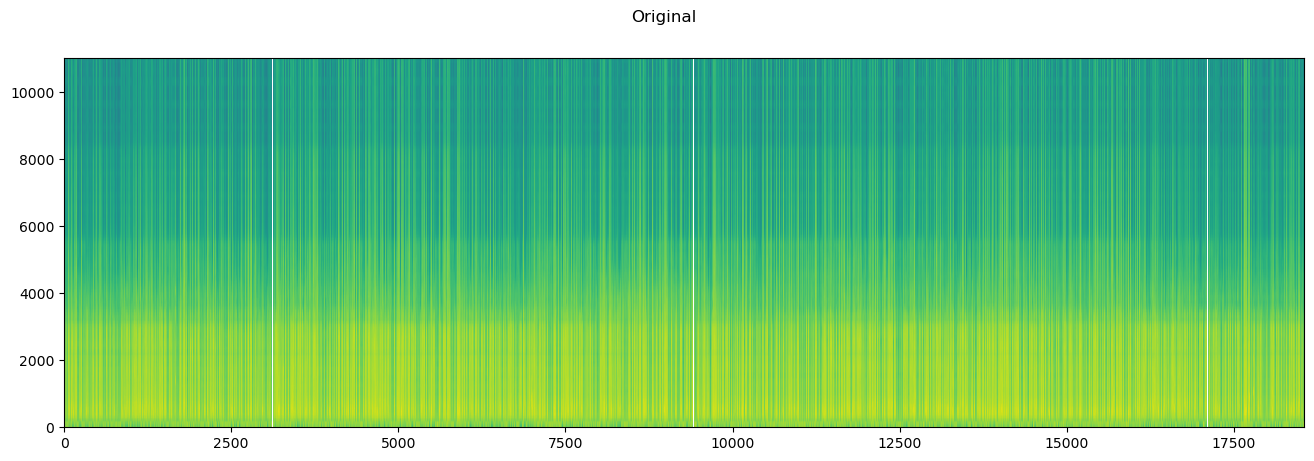

CPU times: user 50.3 s, sys: 11.3 s, total: 1min 1s
Wall time: 58.6 s


In [94]:
%%time
plot_specgram(waveform, sample_rate, title="Original", xlim=(0, waveform.shape[1]/sample_rate))

Shape: (1, 1025, 183714)
Dtype: torch.float32
 - Max:     53665.184
 - Min:      0.000
 - Mean:     1.175
 - Std Dev: 72.590

tensor([[[5.3284e-07, 3.3984e-04, 5.7588e-05,  ..., 5.6268e-02,
          5.6487e-02, 5.0053e-02],
         [3.6377e-07, 3.2762e-04, 2.5615e-04,  ..., 5.1294e-02,
          5.1601e-02, 4.5366e-02],
         [7.4918e-08, 2.9354e-04, 7.3581e-04,  ..., 3.8624e-02,
          3.9194e-02, 3.3588e-02],
         ...,
         [1.9122e-14, 2.0812e-13, 6.0749e-14,  ..., 5.1142e-13,
          3.4775e-13, 2.5136e-11],
         [2.1178e-14, 1.9593e-13, 6.8990e-14,  ..., 6.6241e-13,
          4.5065e-13, 2.3706e-11],
         [2.1670e-14, 1.9079e-13, 7.2318e-14,  ..., 7.3413e-13,
          5.0099e-13, 2.3166e-11]]])



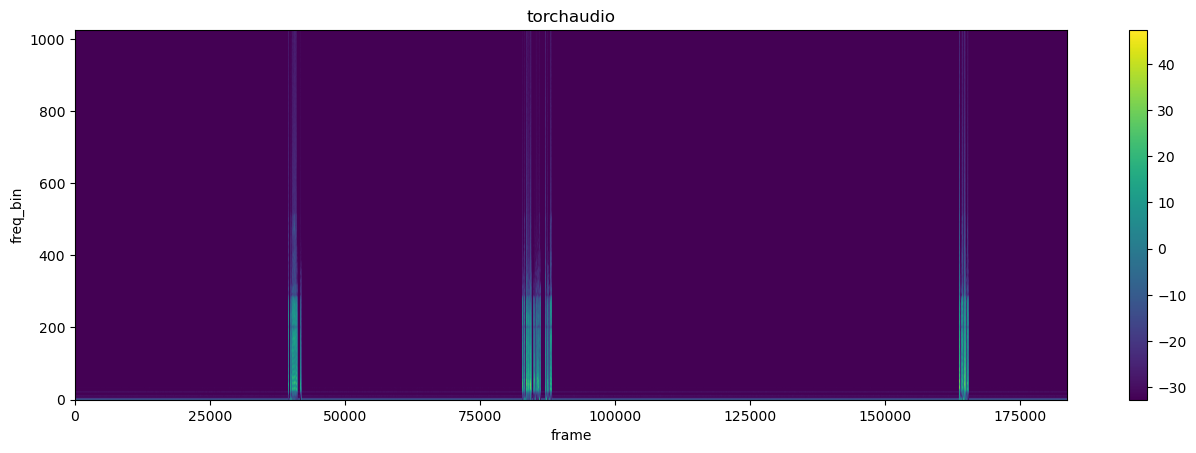

In [21]:
%%time
# Plot a spectrogram (for fun)
n_fft = 2048
win_length = round(0.025*sample_rate)
hop_length = round(0.010*sample_rate)

# define transformation
spectrogram = T.Spectrogram(
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    pad_mode="reflect",
    power=2.0,
)
# Perform transformation
spec = spectrogram(waveform)

print_stats(spec)
plot_spectrogram(spec[0], title='torchaudio')

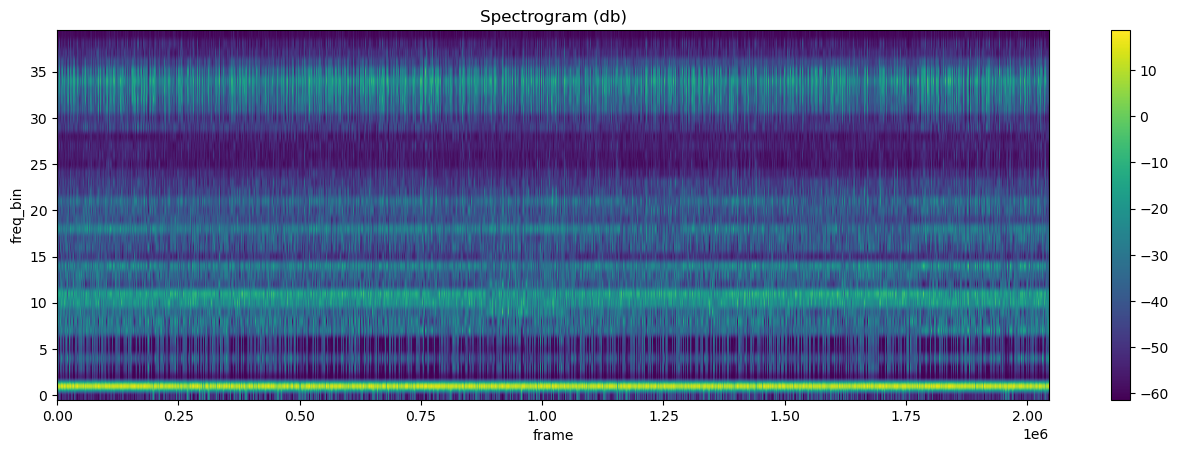

In [73]:
%%time
# Plot MFCC using...

# 1024-point FFT
n_fft = 1024

# window length = 25ms * sample_rate
win_length = round(0.025*sample_rate)
# hop_legnth = 10ms * sample_rate
hop_length = round(0.010*sample_rate)
# 40-dimensional Mel-filterbank
n_mels = 40
n_mfcc = 40

# Use log Mel
mfcc_transform = T.MFCC(
    sample_rate=sample_rate,
    n_mfcc=n_mfcc, 
    log_mels=True)

# Note: Default T.MFCC function uses Hanning window
mfcc = mfcc_transform(waveform)

plot_spectrogram(mfcc[0])

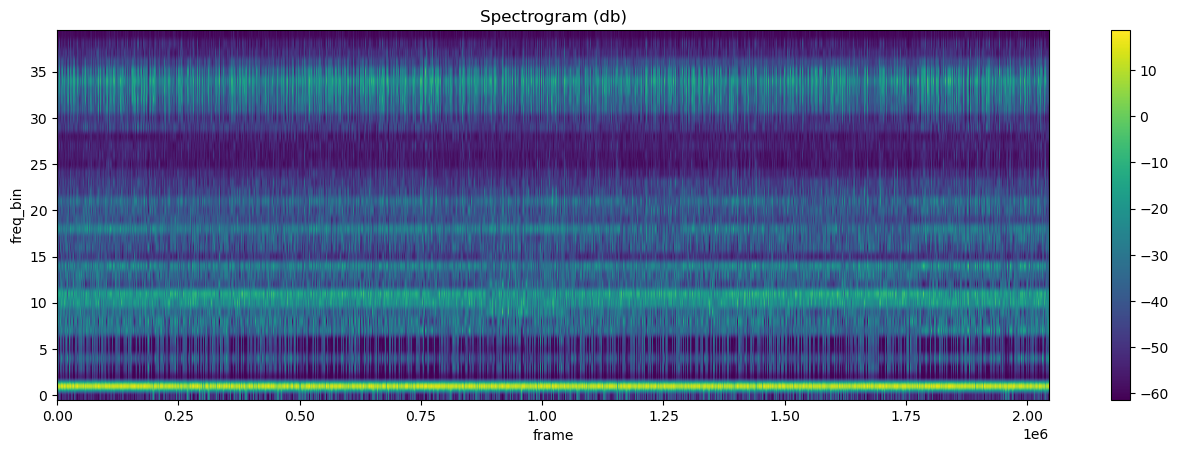

CPU times: user 20.1 s, sys: 6.5 s, total: 26.6 s
Wall time: 10.8 s


In [81]:
%%time
# Compare to MFCC using...

# 2048-point FFT
n_fft = 2048

# window length = 25ms * sample_rate
win_length = round(0.025*sample_rate)
# hop_legnth = 10ms * sample_rate
hop_length = round(0.010*sample_rate)
# 40-dimensional Mel-filterbank
n_mels = 40
n_mfcc = 40

# Use log Mel
mfcc_transform = T.MFCC(
    sample_rate=sample_rate,
    n_mfcc=n_mfcc, 
    log_mels=True)

# Note: Default T.MFCC function uses Hanning window
mfcc2 = mfcc_transform(waveform)

plot_spectrogram(mfcc[0])

In [80]:
%%time
# When we look at the difference in MFCC from 1024-point FFT vs 2048-point FFT there is no difference.
# Note: This is good and makes sense. The Mel filterbank is "binning" the FFT information (40 << 1024 < 2048)
sum(sum(sum(mfcc-mfcc2)))

CPU times: user 7.94 s, sys: 444 ms, total: 8.38 s
Wall time: 6.13 s


tensor(0.)

In [9]:
# Too big to process the entire thing, so split into thirds
n_split = 3
num_frames = round(waveform.size()[1]/n_split)-1
num_frames

136352826

In [10]:
waveform_list = [waveform[0:num_frames],
                waveform[num_frames+1:2*num_frames],
                waveform[2*num_frames+1:]]

In [20]:
torch.cuda.empty_cache() 
print(torch.cuda.memory_reserved(torch.device('cuda')), 
torch.cuda.memory_allocated(torch.device('cuda')), 
torch.cuda.max_memory_allocated(torch.device('cuda')))

0 0 0


In [21]:
%%time
def get_spectrogram(temp_waveform):
    temp_waveform = temp_waveform.to('cuda')
    n_fft = 1024
    #frame_length = round(0.025*sample_rate)
    #frame_shift = round(0.010*sample_rate)

    params = {
        "channel": 0,
        "dither": 0.0,
        "window_type": "hanning",
        "remove_dc_offset": False,
        "round_to_power_of_two": True,
        "sample_frequency": sample_rate,
    }


    specgram = torchaudio.compliance.kaldi.spectrogram(temp_waveform, **params)

    print("Shape of spectrogram: {}".format(specgram.size()))
    del temp_waveform
    torch.cuda.empty_cache() 
get_spectrogram(waveform_list[0])

RuntimeError: CUDA out of memory. Tried to allocate 3.82 GiB (GPU 0; 11.78 GiB total capacity; 9.17 GiB already allocated; 954.94 MiB free; 9.19 GiB reserved in total by PyTorch)

In [22]:
torch.cuda.memory_reserved() 

9867100160

In [54]:
n_fft = 256.0
frame_length = n_fft / sample_rate * 1000.0
frame_shift = frame_length / 2.0

In [55]:
frame_length, frame_shift

(11.609977324263038, 5.804988662131519)

In [58]:
40416944/202083

200.0017022708491

In [34]:
mfcc.shape

torch.Size([1, 40, 202085])

In [35]:
waveform.shape

torch.Size([1, 40416944])

In [32]:
40416944/202085

199.99972288888338

In [14]:
waveform.device

device(type='cpu')

In [20]:
waveform = waveform.to('cpu')
waveform.device

device(type='cpu')

In [17]:
test = F.vad(waveform, sample_rate)
test.shape, waveform.shape

(torch.Size([1, 31760600]), torch.Size([1, 40416944]))

In [ ]:
plt.plot(waveform)